<a href="https://colab.research.google.com/github/Petrofan1/Technosphere/blob/master/Homework%2011/HW11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для начала, подключаем google disk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Теперь подгружаем необходимые библиотеки

In [2]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
from itertools import chain
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.style.use("ggplot")

Объявляем константы

In [3]:
TRAIN_PATH = "/content/drive/MyDrive/Technosphere/Homework 11/data/train"
TEST_PATH = "/content/drive/MyDrive/Technosphere/Homework 11/data/test"
SEED = 42
image_size = (224, 224)
batch_size = 8

Создаем callback, который будет после каждой эпохи отрисовывать графики  

In [5]:
class MetricsCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, metrics_name):
        super().__init__()
        self.loss = []
        self.val_loss = []
        self.metrics = []
        self.val_metrics = []
        self.metrics_name = metrics_name

    def on_epoch_end(self, epoch, logs=None):
        
        self.loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.metrics.append(logs[self.metrics_name])
        self.val_metrics.append(logs[f"val_{self.metrics_name}"])
        
        clear_output(wait=True)
        
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.plot(self.loss, label="loss")
        plt.plot(self.val_loss, label="val_loss")
        plt.legend()

        plt.subplot(122)
        plt.plot(self.metrics, label=self.metrics_name)
        plt.plot(self.val_metrics, label=f"val_{self.metrics_name}")
        plt.legend()
        plt.show()

Объявляем имена классов

In [4]:
id2class = [
    "Palladian architecture",
    "Art Deco architecture",
    "American craftsman style",
    "International style",
    "Queen Anne architecture",
    "American Foursquare architecture",
    "Russian Revival architecture",
    "Colonial architecture",
    "Bauhaus architecture",
    "Postmodern architecture",
    "Tudor Revival architecture",
    "Achaemenid architecture",
    "Art Nouveau architecture",
    "Chicago school architecture",
    "Baroque architecture",
    "Georgian architecture",
    "Ancient Egyptian architecture",
    "Romanesque architecture",
    "Edwardian architecture",
    "Greek Revival architecture",
    "Byzantine architecture",
    "Gothic architecture",
    "Novelty architecture",
    "Beaux-Arts architecture"
]

class_names = [str(id) for id, _ in enumerate(id2class)]

Загружаем тренировочный и контрольный датасеты. От тренировочного сразу отрезаем валидационную часть

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_PATH,
    labels="inferred",
    class_names=class_names,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_PATH,
    labels="inferred",
    class_names=class_names,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_PATH,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 3069 files belonging to 24 classes.
Using 2456 files for training.
Found 3069 files belonging to 24 classes.
Using 613 files for validation.
Found 1512 files belonging to 1 classes.


Добавляем аугментацию: изображения во время обучения будут случайным образом зуммироваться и зеркально отражаться

In [19]:
augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.1, 0.3)),
    ],
    name="augmentation"
)

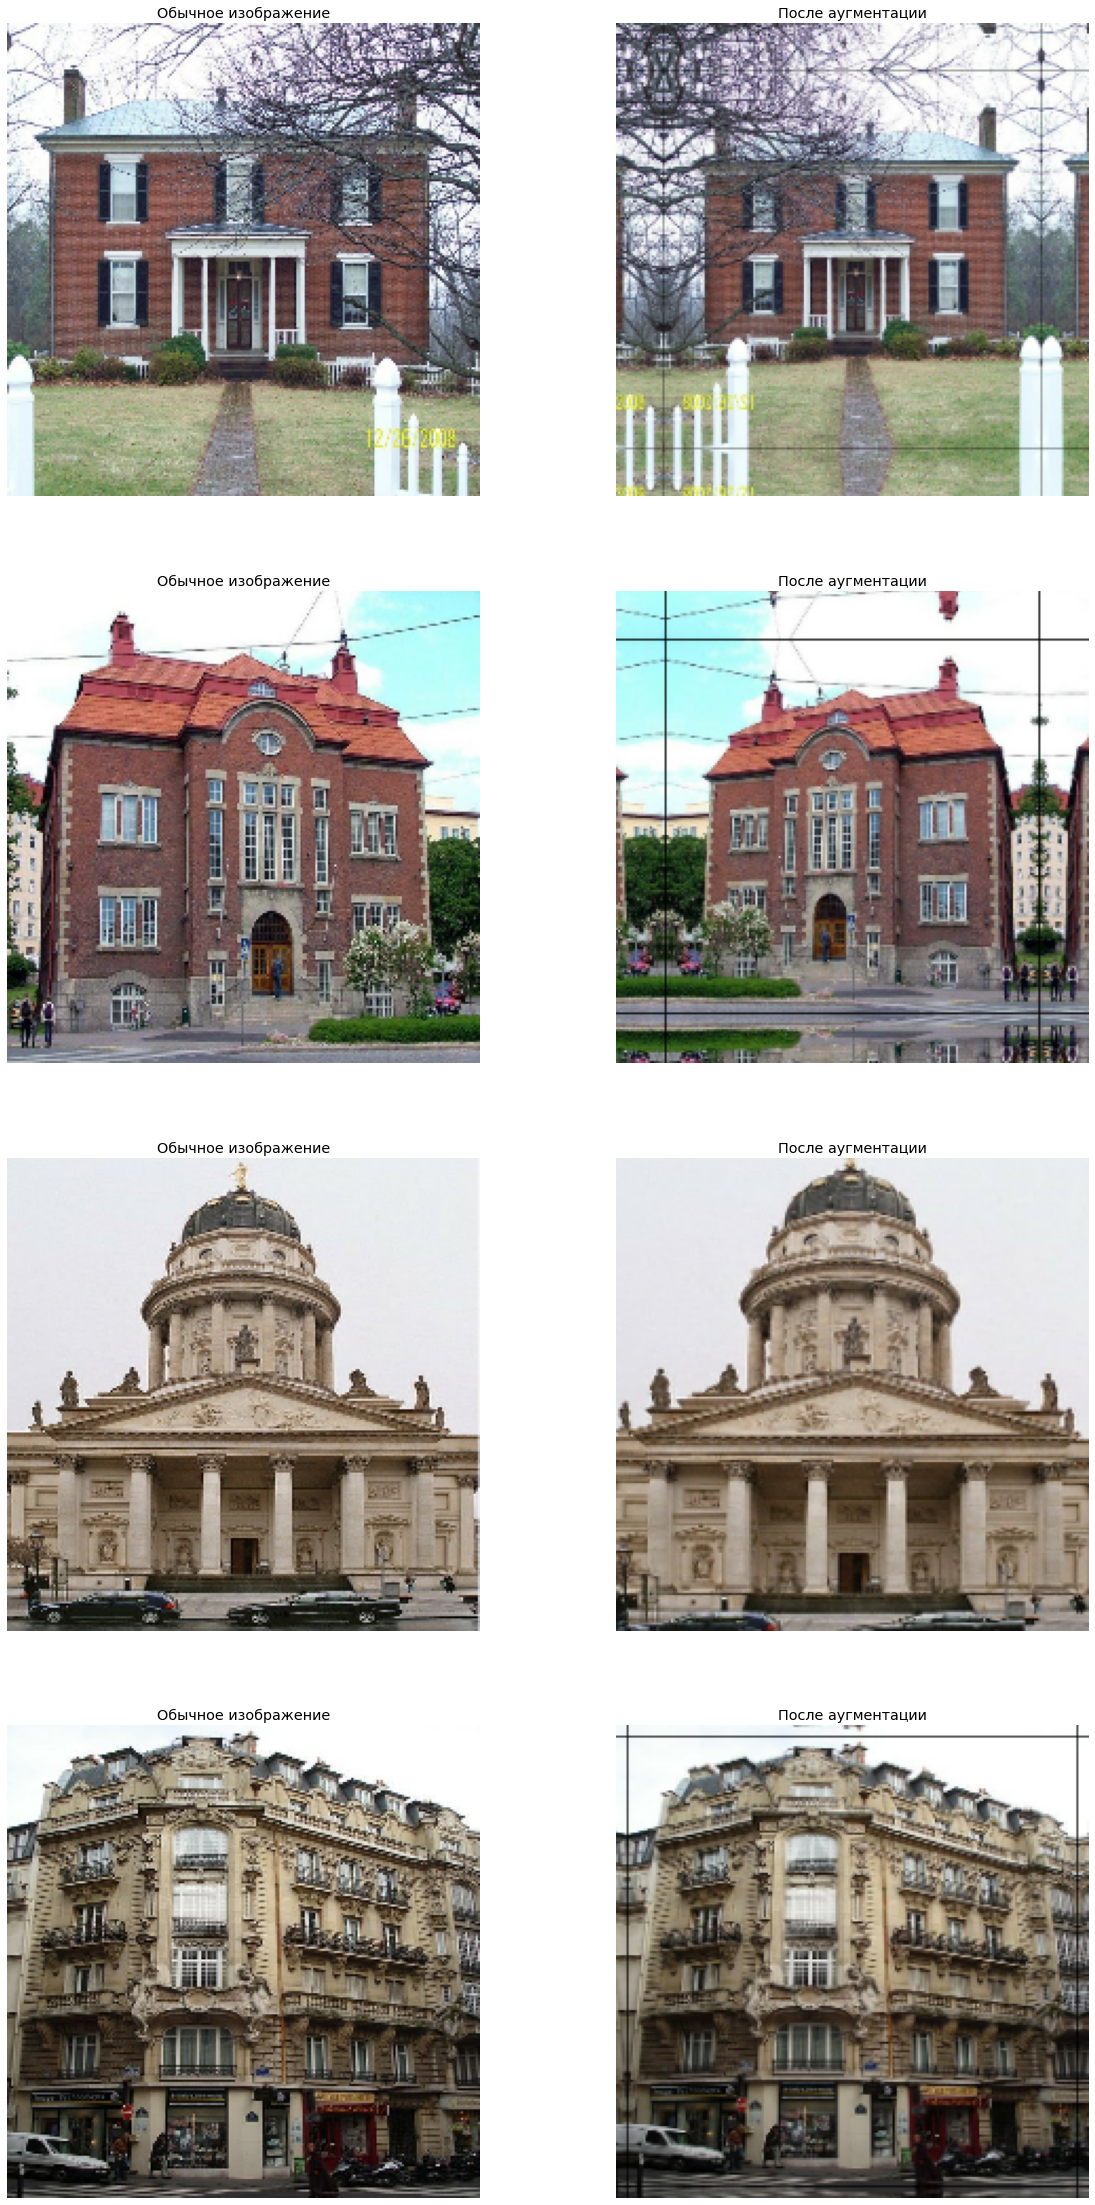

In [20]:
fig, ax = plt.subplots(nrows=int(batch_size/2), ncols=2, figsize=(20, 10*int(batch_size/2)))
for image, labels in train_ds.take(1):
  for i in range(int(batch_size/2)):
        ax[i, 0].set_title("Обычное изображение")
        ax[i, 0].imshow(image[i].numpy().astype("uint8"))
        ax[i, 0].axis("off")
        ax[i, 1].set_title("После аугментации")
        ax[i, 1].imshow(augmentation(image)[i].numpy().astype("uint8"))
        ax[i, 1].axis("off")

Загружаем предобученную сеть ResNet 152

In [28]:
backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
i = tf.keras.layers.Input(list(image_size) + [3], dtype=tf.float32)
x = tf.keras.applications.resnet.preprocess_input(i)
x = backbone(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

Слои предобученной сети пока делаем не дообучаемыми

In [29]:
for layer in backbone.layers:
	layer.trainable = False

Компилируем и смотрим что получилось

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, None, None, 2048)  58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 58,370,944
Trainable params: 0
Non-trainable params: 58,370,944
_________________________________________________________________


Прогоняем исходный тренировочный датасет через обученную сеть и еще дважды прогоняем, применяя аугментацию

In [31]:
train_dupl = []
y_train = []
for image, labels in train_ds:
    predict = model(image).numpy()
    y_train.append(labels)
    for i in predict:
      train_dupl.append(i)
for i in range(2):
  for image, labels in train_ds:
      predict = model(augmentation(image)).numpy()
      y_train.append(labels)
      for i in predict:
        train_dupl.append(i)
y_train = np.array(y_train).ravel()
len(y_train)

7368

Валидационную часть так же прогоняем через эту сеть 

In [32]:
val_dupl = []
y_val = []
for image, labels in val_ds:
  predict = model(image).numpy()
  for i in predict:
    val_dupl.append(i)
  y_val.append(labels.numpy())
y_val = list(chain.from_iterable(y_val))
y_val = np.array(y_val)
len(y_val)

613

In [33]:
train_dupl = np.array(train_dupl)
val_dupl = np.array(val_dupl)

In [34]:
train_dupl.shape, val_dupl.shape

((7368, 2048), (613, 2048))

К предобученной сети добавим новую "голову", а именно трехслойную полносвязную сеть

In [35]:
inp  = tf.keras.layers.Input(train_dupl[0].shape, dtype=tf.float32)
x = tf.keras.layers.Dense(1024, activation="relu")(inp)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=len(id2class), activation="softmax")(x)
model_2 = tf.keras.Model(inputs=[inp], outputs=[x])

Компилируем и смотрим что получилось

In [36]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)
model_2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

Обучаем на заранее подготовленных данных. Благодаря подготовки голова обучится очень быстро

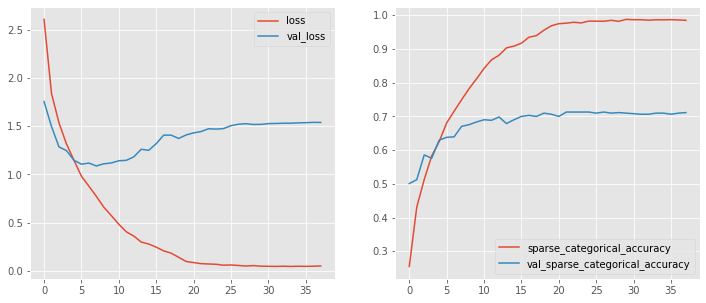

921/921 [==============================] - 2s 3ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9849 - val_loss: 1.5382 - val_sparse_categorical_accuracy: 0.7113


In [37]:
history = model_2.fit(
                    train_dupl, y_train,
                    validation_data = (val_dupl, y_val),
                    epochs=100, 
                    batch_size = batch_size,
                    shuffle = True,
                    use_multiprocessing = True, 
                    callbacks = [
                                 tf.keras.callbacks.EarlyStopping(patience=30),
                                 tf.keras.callbacks.ReduceLROnPlateau(),
                                 MetricsCallback(metrics_name="sparse_categorical_accuracy")
                    ]
)

В предобученной сети размораживаем последние 30 слоев и убеждаемся, что количество обучаемых параметров увеличилось

In [40]:
for layer in backbone.layers[-30:]:
	layer.trainable = True
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, None, None, 2048)  58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 58,370,944
Trainable params: 14,450,176
Non-trainable params: 43,920,768
_________________________________________________________________


Соединяем две модели вместе

In [41]:
i = tf.keras.layers.Input(list(image_size) + [3], dtype=tf.float32)
x = augmentation(i)
x = tf.keras.applications.resnet.preprocess_input(x)
x = backbone(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = model_2(x)
main = tf.keras.Model(inputs=[i], outputs=[x])
main.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_3 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152 (Functional)       (None, None, None, 2048)  58370944  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
functional_7 (Functional)    (None, 24)              

Дообучаем получившуюся конструкцию на маленьком темпе обучения

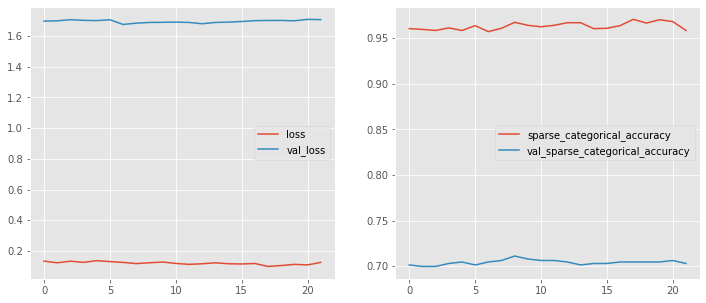

307/307 [==============================] - 51s 167ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9585 - val_loss: 1.7065 - val_sparse_categorical_accuracy: 0.7031


In [45]:
main.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)
history = main.fit(
                    train_ds,
                    validation_data = val_ds, 
                    epochs=100, 
                    workers = 8, 
                    use_multiprocessing = True, 
                    shuffle=True,
                    callbacks = [
                                 tf.keras.callbacks.EarlyStopping(patience=15),
                                 tf.keras.callbacks.ReduceLROnPlateau(),
                                 MetricsCallback(metrics_name="sparse_categorical_accuracy")
                    ]
)

Делаем контрольное предсказание и сохраняем

In [43]:
import os
file_ids = [os.path.splitext(filename)[0] for filename in sorted(os.listdir(TEST_PATH + "/1/"))]

In [44]:
predictions = np.hstack([
  tf.argmax(main(batch), axis=1).numpy()
  for batch, _ in test_ds
])
predictions

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
submit = pd.DataFrame({"Id": file_ids, "Category": predictions})
submit.to_csv("SmirnovGS.csv", index=False)

In [342]:
from google.colab import files
files.download("SmirnovGS.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>